In [1]:
import numpy as np
import pandas as pd
from pygama import lh5
import matplotlib.pyplot as plt

In [2]:
# Load Data

group_path = '/icpcs/icpc1/dsp'
det_name = 'P43415A'

f_list = ['dsp/Run70*_dsp.lh5']
#f_list = ['dsp/Run700[567]?_dsp.lh5']
par_list = ['trapEftp', 'dcr']
df = lh5.load_dfs(f_list, par_list, group_path, verbose=False)
df

loading data for dsp/Run70053_dsp.lh5 dsp/Run70054_dsp.lh5 dsp/Run70055_dsp.lh5 dsp/Run70056_dsp.lh5 dsp/Run70057_dsp.lh5 dsp/Run70058_dsp.lh5 dsp/Run70059_dsp.lh5 dsp/Run70060_dsp.lh5 dsp/Run70061_dsp.lh5 dsp/Run70062_dsp.lh5 dsp/Run70063_dsp.lh5 dsp/Run70064_dsp.lh5 dsp/Run70065_dsp.lh5 dsp/Run70066_dsp.lh5 dsp/Run70067_dsp.lh5 dsp/Run70068_dsp.lh5 dsp/Run70069_dsp.lh5 dsp/Run70070_dsp.lh5 dsp/Run70071_dsp.lh5 dsp/Run70072_dsp.lh5 dsp/Run70073_dsp.lh5 dsp/Run70074_dsp.lh5 dsp/Run70075_dsp.lh5 dsp/Run70076_dsp.lh5 dsp/Run70077_dsp.lh5 dsp/Run70078_dsp.lh5 dsp/Run70079_dsp.lh5 dsp/Run70080_dsp.lh5 dsp/Run70081_dsp.lh5 dsp/Run70082_dsp.lh5 dsp/Run70083_dsp.lh5 dsp/Run70084_dsp.lh5 dsp/Run70085_dsp.lh5 dsp/Run70086_dsp.lh5 dsp/Run70087_dsp.lh5 dsp/Run70088_dsp.lh5 dsp/Run70089_dsp.lh5 dsp/Run70090_dsp.lh5 dsp/Run70091_dsp.lh5 dsp/Run70092_dsp.lh5 dsp/Run70093_dsp.lh5 dsp/Run70094_dsp.lh5 dsp/Run70095_dsp.lh5 dsp/Run70096_dsp.lh5 dsp/Run70097_dsp.lh5 dsp/Run70098_dsp.lh5 dsp/Run70099_dsp.

,trapEftp,dcr
0,0.465894,0.122106
1,1.133867,-0.212462
2,0.997237,0.208431
3,-0.128352,0.274766
4,0.444162,-0.070870
...,...,...
1189621,586.388611,0.747065
1189622,1.052020,-0.975908
1189623,887.384460,2.350367
1189624,132.763031,-0.100743


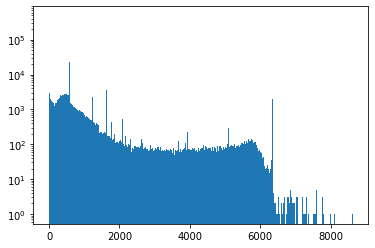

In [3]:
#check that the E spectrum looks good
plt.hist(df['trapEftp'], bins=1500)
plt.yscale('log')
plt.show()

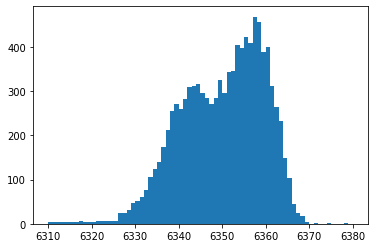

max at 6357.5
fwhm = 10.3 keV


In [4]:
# from the previous plot we get the following ranges for the 2615 peak zoom:
tl_range = (6310,6380)
tl_bins = 70

# Zoom in on 2615
hist = plt.hist(df['trapEftp'], bins=tl_bins, range=tl_range)
plt.show()

# Calculate the FWHM
bins = hist[1]
bin_centers = 0.5*(bins[:-1] + bins[1:])
hist = hist[0]
imode = np.argmax(hist)
mode = bin_centers[imode]
print("max at", mode)
E_scale = 2614.5/mode
ineg = imode
while(hist[ineg]>hist[imode]/2): ineg -= 1
ipos = imode
while(hist[ipos]>hist[imode]/2): ipos += 1
print(f'fwhm = {(bins[ipos-1] - bins[ineg])*E_scale:0.3g} keV')

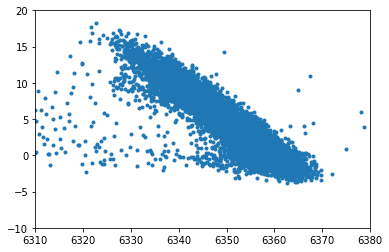

In [5]:
# Look at dcr for use in charge trapping correction
plt.plot(df['trapEftp'], df['dcr'], '.')
plt.xlim(*tl_range)
plt.ylim(-10,20)
plt.show()

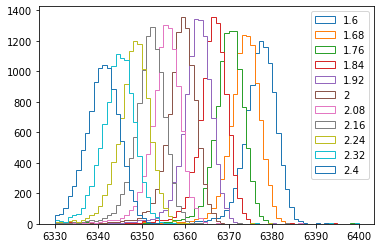

0            0.758948
1            0.623959
2            1.497470
3            0.531087
4            0.274075
              ...    
1189621    588.181580
1189622     -1.290158
1189623    893.025330
1189624    132.521255
1189625      6.111118
Length: 1189626, dtype: float32

In [6]:
# Get a rough charge trapping correction from the above plot
ctc = 2
tl_shift = 20
tl_dcr_range = (tl_range[0]+tl_shift, tl_range[1]+tl_shift)

# Now scan to get the best value
fracs = np.linspace(0.8, 1.2, 11)
for frac in fracs:
    ctcf = frac*ctc
    plt.hist((df['trapEftp'] + ctcf*df['dcr']+(1-frac)*100), bins=tl_bins, range=tl_dcr_range, histtype='step', label=f'{ctcf:.3g}')
plt.legend()
plt.show()
df['trapEftp'] + ctcf*df['dcr']

In [7]:
# Now build the charge-trapping-corrected energy column
# E-dependence was eyeballed looking at the plots below
ctc = 1.9
df['ctcE'] = df['trapEftp'] + ctc*df['dcr']*(df['trapEftp']+3000)/(6360+3000)
df

,trapEftp,dcr,ctcE
0,0.465894,0.122106,0.540265
1,1.133867,-0.212462,1.004434
2,0.997237,0.208431,1.124208
3,-0.128352,0.274766,0.038966
4,0.444162,-0.070870,0.400998
...,...,...,...
1189621,586.388611,0.747065,586.932495
1189622,1.052020,-0.975908,0.457509
1189623,887.384460,2.350367,889.239136
1189624,132.763031,-0.100743,132.698959


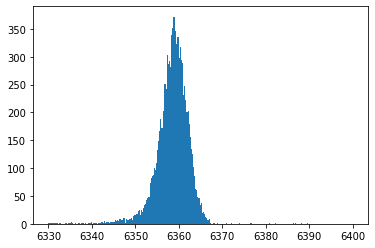

max at 6358.875
fwhm = 2.47 keV


In [29]:
# plot the Tl208 peak...
hist = plt.hist(df['ctcE'], bins=tl_bins*4, range=tl_dcr_range)
plt.show()

#... and measure its FWHM
bins = hist[1]
bin_centers = 0.5*(bins[:-1] + bins[1:])
hist = hist[0]
imode = np.argmax(hist)
mode = bin_centers[imode]
print("max at", mode)
E_scale = 2614.5/mode
ineg = imode
while(hist[ineg]>hist[imode]/2): ineg -= 1
ipos = imode
while(hist[ipos]>hist[imode]/2): ipos += 1
print(f'fwhm = {(bins[ipos-1] - bins[ineg])*E_scale:0.3g} keV')

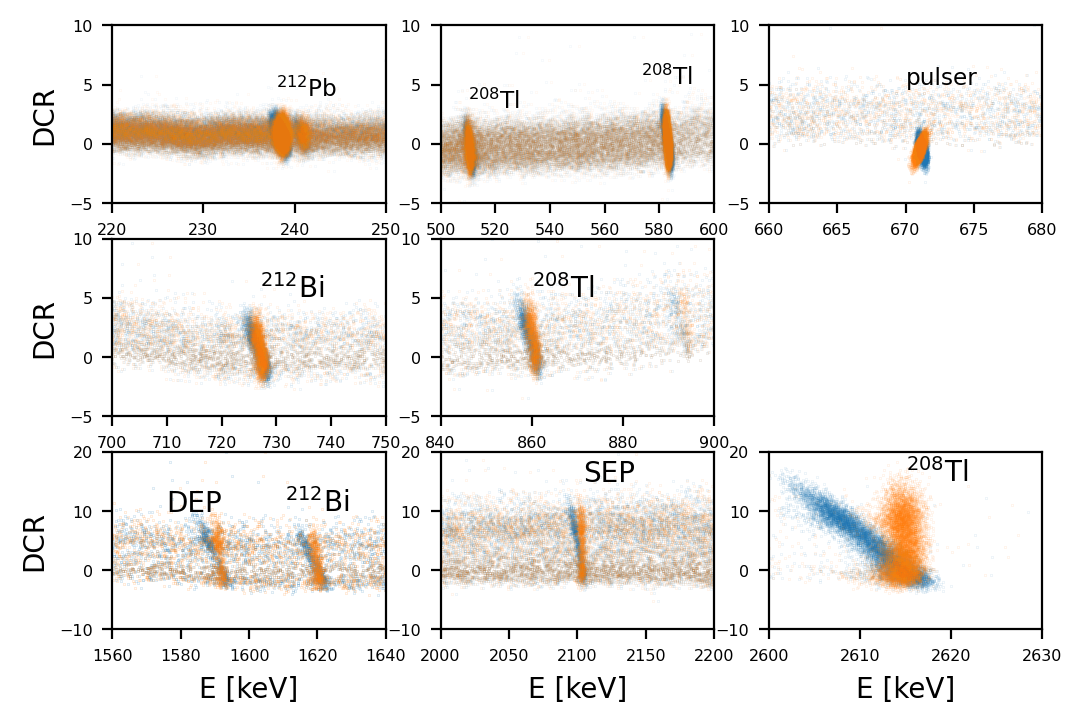

In [9]:
# Check "by eye" how the ctc works across all energies.

plt.figure().set_dpi(200)
ms = 0.05
fs = 'small'
tfs = 'xx-small'

plt.subplot(331)
plt.text(238, 4, '$^{212}$Pb', size=fs)
plt.plot(df['trapEftp']*E_scale, df['dcr'], '.', markersize=ms/2)
plt.plot(df['ctcE']*E_scale, df['dcr'], '.', markersize=ms/2)
plt.xlim(220,250) 
plt.gca().set_ylabel('DCR')
plt.ylim(-5,10)
plt.gca().tick_params(axis='both', which='major', labelsize=tfs)

plt.subplot(332)
plt.text(510, 3, '$^{208}$Tl', size=fs)
plt.text(583, 5, '$^{208}$Tl', size=fs, ha='center')
plt.plot(df['trapEftp']*E_scale, df['dcr'], '.', markersize=ms/2)
plt.plot(df['ctcE']*E_scale, df['dcr'], '.', markersize=ms/2)
plt.xlim(500,600)
plt.ylim(-5,10)
plt.gca().tick_params(axis='both', which='major', labelsize=tfs)

plt.subplot(333)
plt.text(670, 5, 'pulser', size=fs)
plt.plot(df['trapEftp']*E_scale, df['dcr'], '.', markersize=ms)
plt.plot(df['ctcE']*E_scale, df['dcr'], '.', markersize=ms)
plt.xlim(660,680)
plt.ylim(-5,10)
plt.gca().tick_params(axis='both', which='major', labelsize=tfs)

plt.subplot(334)
plt.text(727, 5, '$^{212}$Bi')
plt.plot(df['trapEftp']*E_scale, df['dcr'], '.', markersize=ms)
plt.plot(df['ctcE']*E_scale, df['dcr'], '.', markersize=ms)
plt.xlim(700,750)
plt.gca().set_ylabel('DCR')
plt.ylim(-5,10)
plt.gca().tick_params(axis='both', which='major', labelsize=tfs)

plt.subplot(335)
plt.text(860, 5, '$^{208}$Tl')
plt.plot(df['trapEftp']*E_scale, df['dcr'], '.', markersize=ms)
plt.plot(df['ctcE']*E_scale, df['dcr'], '.', markersize=ms)
plt.xlim(840,900)
plt.ylim(-5,10)
plt.gca().tick_params(axis='both', which='major', labelsize=tfs)

plt.subplot(337)
plt.text(1592, 10, 'DEP', ha='right')
plt.text(1620, 10, '$^{212}$Bi', ha='center')
plt.plot(df['trapEftp']*E_scale, df['dcr'], '.', markersize=ms*2)
plt.plot(df['ctcE']*E_scale, df['dcr'], '.', markersize=ms*2)
plt.gca().set_xlabel('E [keV]')
plt.xlim(1560,1640)
plt.gca().set_ylabel('DCR')
plt.ylim(-10,20)
plt.gca().tick_params(axis='both', which='major', labelsize=tfs)

plt.subplot(338)
plt.text(2104, 15, 'SEP')
plt.plot(df['trapEftp']*E_scale, df['dcr'], '.', markersize=ms)
plt.plot(df['ctcE']*E_scale, df['dcr'], '.', markersize=ms)
plt.gca().set_xlabel('E [keV]')
plt.xlim(2000,2200)
plt.ylim(-10,20)
plt.gca().tick_params(axis='both', which='major', labelsize=tfs)

plt.subplot(339)
plt.text(2615, 15, '$^{208}$Tl')
plt.plot(df['trapEftp']*E_scale, df['dcr'], '.', markersize=ms)
plt.plot(df['ctcE']*E_scale, df['dcr'], '.', markersize=ms)
plt.gca().set_xlabel('E [keV]')
plt.xlim(2600,2630) # 208Tl 2615
plt.ylim(-10,20)
plt.gca().tick_params(axis='both', which='major', labelsize=tfs)

plt.show()